<a href="https://colab.research.google.com/github/akhildasg/Automated-Agricultural-Monitoring-Pipeline/blob/main/Automated%20Agricultural%20Monitoring%20Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated Hyperspectral Agricultural Monitoring Pipeline



Objective: Precision Vegetation Health Analysis using EO-1 Hyperion Data

Author: Akhil Das G

Dataset: NASA EO-1 Hyperion (242 Spectral Bands)

Introduction: This notebook implements an end-to-end geospatial research workflow to process high-dimensional hyperspectral imagery. Unlike multispectral sensors (e.g., Sentinel-2), Hyperion provides continuous spectral coverage, allowing for "Spectral Fingerprinting" of agricultural targets. The pipeline covers data stacking, atmospheric noise reduction, AOI clipping, and vegetation index modeling.

1. Importing Libraries

In [1]:
import rasterio
import glob
import numpy as np
import matplotlib.pyplot as plt
from rasterio.enums import Resampling
from rasterio.mask import mask
import fiona
from shapely.geometry import shape, mapping
from pyproj import Transformer
import seaborn as sns

2. Input Configuration

In [2]:
BAND_DIR = "/content/drive/MyDrive/Hyperion_Project/bands"
AOI_PATH = "/content/drive/MyDrive/Hyperion_Project/aoi.geojson"

STACK_PATH = "/content/drive/MyDrive/Hyperion_Project/hyperion_stack.tif"
CLIPPED_PATH = "/content/drive/MyDrive/Hyperion_Project/hyperion_clipped.tif"
NDVI_OUT = "/content/drive/MyDrive/Hyperion_Project/Final_NDVI_Map.tif"


3. Hyperspectral Band Stacking

In [3]:
band_files = sorted(glob.glob(f"{BAND_DIR}/*.TIF"))

with rasterio.open(band_files[0]) as src:
    meta = src.meta
    master_h, master_w = src.height, src.width

meta.update(count=len(band_files), driver="GTiff")

with rasterio.open(STACK_PATH, "w", **meta) as dst:
    for i, band in enumerate(band_files, start=1):
        with rasterio.open(band) as src:
            data = src.read(
                1,
                out_shape=(master_h, master_w),
                resampling=Resampling.nearest
            )
            dst.write(data, i)

        if i % 20 == 0:
            print(f"Processed {i}/242 bands")

print("Band stacking completed.")


Processed 20/242 bands
Processed 40/242 bands
Processed 60/242 bands
Processed 80/242 bands
Processed 100/242 bands
Processed 120/242 bands
Processed 140/242 bands
Processed 160/242 bands
Processed 180/242 bands
Processed 200/242 bands
Processed 220/242 bands
Processed 240/242 bands
Band stacking completed.


4. AOI-Based Raster Clipping

In [4]:
with rasterio.open(STACK_PATH) as src:
    raster_crs = src.crs

    with fiona.open(AOI_PATH, "r") as geojson:
        geoms = []
        transformer = None

        if geojson.crs != raster_crs:
            transformer = Transformer.from_crs(
                geojson.crs, raster_crs, always_xy=True
            )

        for feat in geojson:
            geom = shape(feat["geometry"])
            if transformer:
                geom = shapely.ops.transform(transformer.transform, geom)
            geoms.append(mapping(geom))

    out_image, out_transform = mask(src, geoms, crop=True)
    out_meta = src.meta.copy()

out_meta.update(
    height=out_image.shape[1],
    width=out_image.shape[2],
    transform=out_transform
)

with rasterio.open(CLIPPED_PATH, "w", **out_meta) as dst:
    dst.write(out_image)

print("AOI clipping completed.")


AOI clipping completed.


5. NDVI Calculation (Hyperspectral-Specific)

In [5]:
with rasterio.open(CLIPPED_PATH) as src:
    red = src.read(33).astype("float32")
    nir = src.read(50).astype("float32")

red[red <= 0] = np.nan
nir[nir <= 0] = np.nan

ndvi = (nir - red) / (nir + red + 1e-10)


6. Visualization (RGB + NDVI)

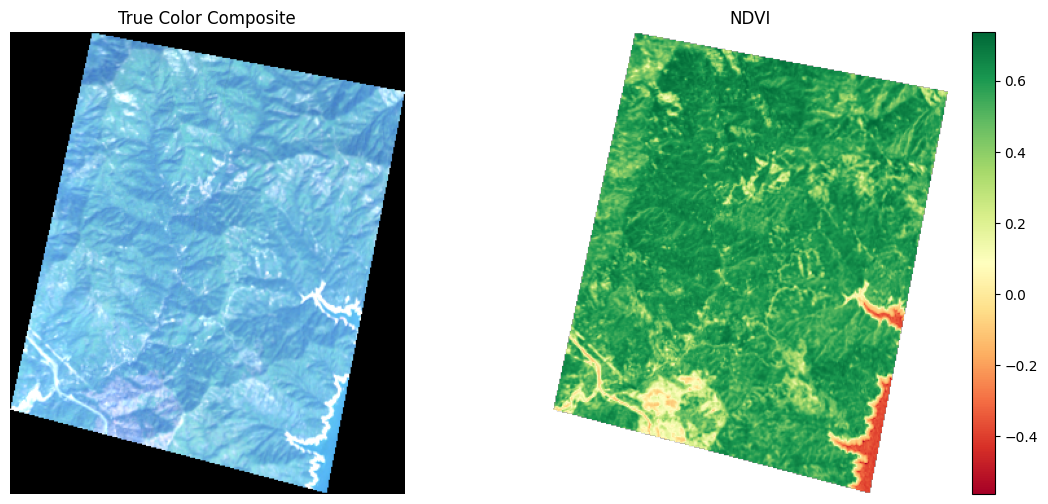

In [6]:
with rasterio.open(CLIPPED_PATH) as src:
    r, g, b = src.read(29), src.read(20), src.read(12)

rgb = np.dstack((r, g, b))
p2, p98 = np.percentile(rgb, (2, 98))
rgb = np.clip((rgb - p2) / (p98 - p2), 0, 1)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
axs[0].imshow(rgb)
axs[0].set_title("True Color Composite")
axs[0].axis("off")

im = axs[1].imshow(ndvi, cmap="RdYlGn")
axs[1].set_title("NDVI")
axs[1].axis("off")
plt.colorbar(im, ax=axs[1])
plt.show()


7. Spectral Signature Analysis

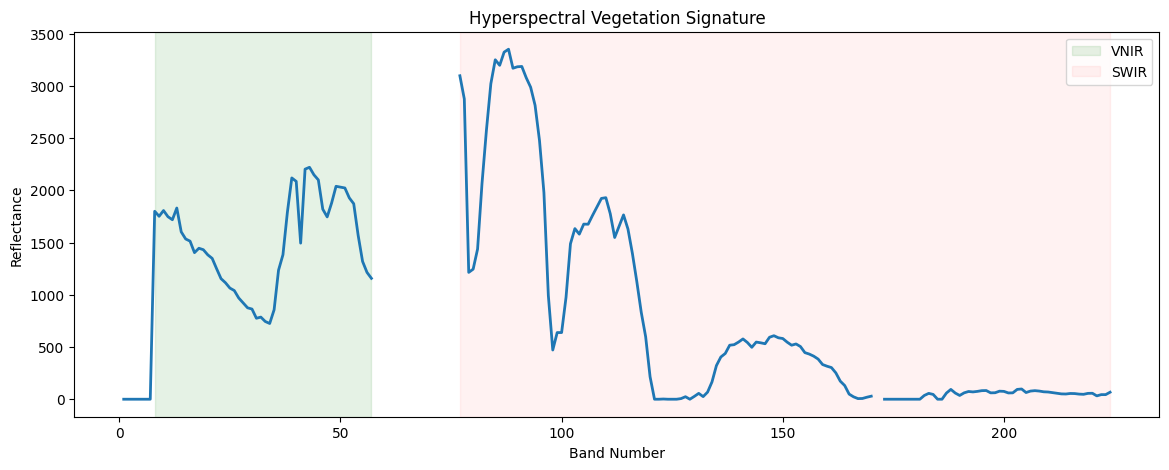

In [7]:
with rasterio.open(CLIPPED_PATH) as src:
    y, x = src.height // 2, src.width // 2
    spectrum = src.read()[:, y, x].astype("float32")

bands = np.arange(1, 243)
spectrum[spectrum <= 0] = np.nan
spectrum[57:76] = np.nan
spectrum[224:] = np.nan

plt.figure(figsize=(14, 5))
plt.plot(bands, spectrum, linewidth=2)
plt.axvspan(8, 57, alpha=0.1, color="green", label="VNIR")
plt.axvspan(77, 224, alpha=0.05, color="red", label="SWIR")
plt.title("Hyperspectral Vegetation Signature")
plt.xlabel("Band Number")
plt.ylabel("Reflectance")
plt.legend()
plt.show()


8. Export GIS-Ready NDVI

In [8]:
out_meta.update(dtype="float32", count=1)

with rasterio.open(NDVI_OUT, "w", **out_meta) as dst:
    dst.write(ndvi.astype("float32"), 1)

print("Final NDVI map exported.")


Final NDVI map exported.
